**Source:** Series Transformer from scratch of Umar Jamil youtube.  
**Link:**: https://www.youtube.com/watch?v=bCz4OMemCcA.

# 0. Why Transformer?

Before Transformers, models like Recurrent Neural Networks (**RNNs**) and Long Short-Term Memory networks (**LSTMs**) were widely used for sequence tasks. The core idea behind these models is to remember previous words in a sequence, as earlier words influence those that follow.

However, RNNs have a fundamental limitation: they process sequences step by step, **adding** the embedding of the current word to the previous context. Over time, this approach causes the model to forget earlier words, especially in long sequences. While LSTMs were introduced to address this problem by adding mechanisms like **gates** to retain more information, their improvement was still limited.

This is where Transformers come in. They solve the limitations of RNNs and LSTMs by using an attention **mechanism**. Unlike sequential processing, the attention mechanism allows Transformers to focus on all words in a sequence simultaneously, regardless of their position. Combined with **positional encoding**, Transformers achieve a much better understanding of context and relationships between words, leading to superior performance in remembering and interpreting long-range dependencies in sequences.

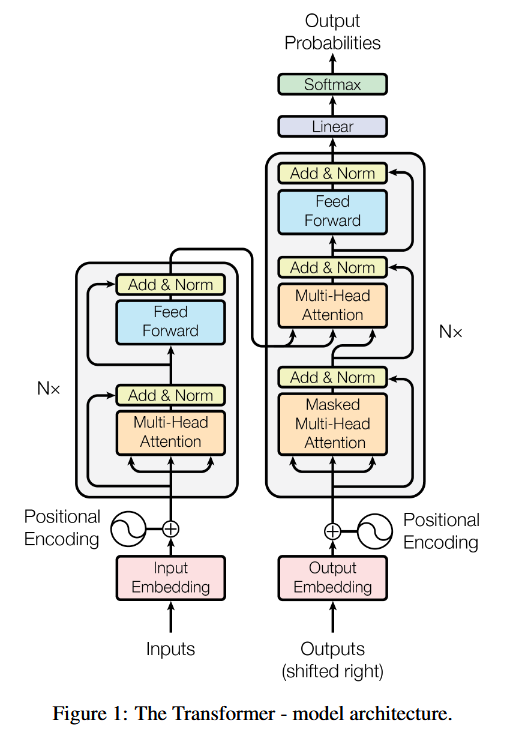

In [44]:
from IPython.display import Image
Image("Image/transformer_architecture.png")

# 1. Library

In [45]:
import torch
import torch.nn as nn
import math

# 2. InputEmbedding

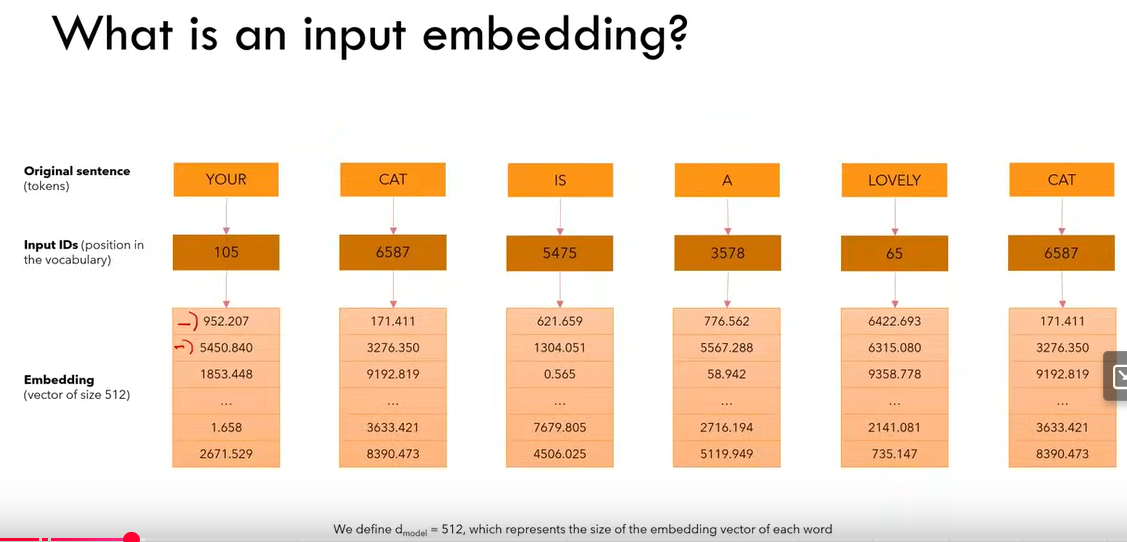

In [46]:
Image("Image/InputEncoding_minhhoa1.png")

In [6]:
class InputEmbedding(nn.Module):
    def __init__(self, d_model:int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        # (batch, seq_len) --> (batch, seq_len, d_model)
        # Multiply by sqrt(d_model) to scale the embeddings according to the paper
        return self.embedding(x) * math.sqrt(self.d_model)

This class implements an input embedding layer for a Transformer model. It processes a sentence and converts it into a fixed-length vector representation suitable for the model.

Step-by-Step Explanation:
1. **Tokenization**: Sentence --> split --> individual words (tokens) --> look up index in vocab --> index (have Unknown element).
2. **Fixed-Length Representation**: Padding or remove to get fixed-length sentence.
3. **Embedding**: passed through an embedding layer (nn.Embedding), **each word** --> dense vector d_model (512) dimensions. Output/sqrt(d_model) --> numerical stability)

**Example**:

In [25]:
# Parameters
d_model = 512       # Dimensionality of embedding vectors
vocab_size = 10000  # Vocabulary size (number of unique tokens)
seq_length = 10     # Length of the sentence (padded if necessary)
batch_size = 1      # Single sentence (batch size of 1 for simplicity)

# Initialize the InputEmbedding layer
embedding_layer = InputEmbedding(d_model, vocab_size)

# Real example sentence
sentence = "The quick brown fox jumps over the lazy nam"
print(f"Sentence: '{sentence}'")

# Step 1: Tokenize the sentence (for demonstration, use a simple tokenizer)
# Vocabulary mapping (dummy indices for simplicity)
vocab = {
    "the": 0, "quick": 1, "brown": 2, "fox": 3,
    "jumps": 4, "over": 5, "lazy": 6, "dog": 7, "[UNK]": 8
}

# Tokenize and convert to indices
token_indices = [vocab.get(word.lower(), vocab["[UNK]"]) for word in sentence.split()]
print(f"\nToken indices:, {token_indices} with len = {len(token_indices)}.")

# Step 2: Convert to a tensor and pad/truncate to seq_length
token_tensor = torch.tensor([token_indices + [0] * (seq_length - len(token_indices))])
print("Padded token tensor (input):")
print(token_tensor, token_tensor.shape)

# Step 3: Pass through the embedding layer
output = embedding_layer(token_tensor)

# Step 4: Print the output
print("\nOutput shape:", output.shape)
print("Output ",output)


Sentence: 'The quick brown fox jumps over the lazy nam'

Token indices:, [0, 1, 2, 3, 4, 5, 0, 6, 8] with len = 9.
Padded token tensor (input):
tensor([[0, 1, 2, 3, 4, 5, 0, 6, 8, 0]]) torch.Size([1, 10])

Output shape: torch.Size([1, 10, 512])
Output  tensor([[[ -2.1628, -14.6844, -12.3339,  ..., -20.3701,  -8.5941,  16.0327],
         [-39.6845,   1.0159,   6.9766,  ..., -24.3728,  -1.2853, -24.1025],
         [ -6.7271, -21.4438, -23.2080,  ..., -15.9166,  16.4517,  11.2702],
         ...,
         [ -9.8735, -26.3320,  11.6148,  ...,   5.5839, -22.0360,   4.6702],
         [ -6.5313, -22.8171, -16.2426,  ...,  17.1317, -23.6093, -30.5427],
         [ -2.1628, -14.6844, -12.3339,  ..., -20.3701,  -8.5941,  16.0327]]],
       grad_fn=<MulBackward0>)


# 3. Positional encoding

- Adds positional information to the embeddings, enabling the Transformer to understand the order of words in a sequence.
- Base on formula showed in Paper attention is all you need.
- **Positional Encoding**: Only need calculate once, then reuse it with every sentence.
- **Forward:** Create PE once, then adding with Input embedding of input.

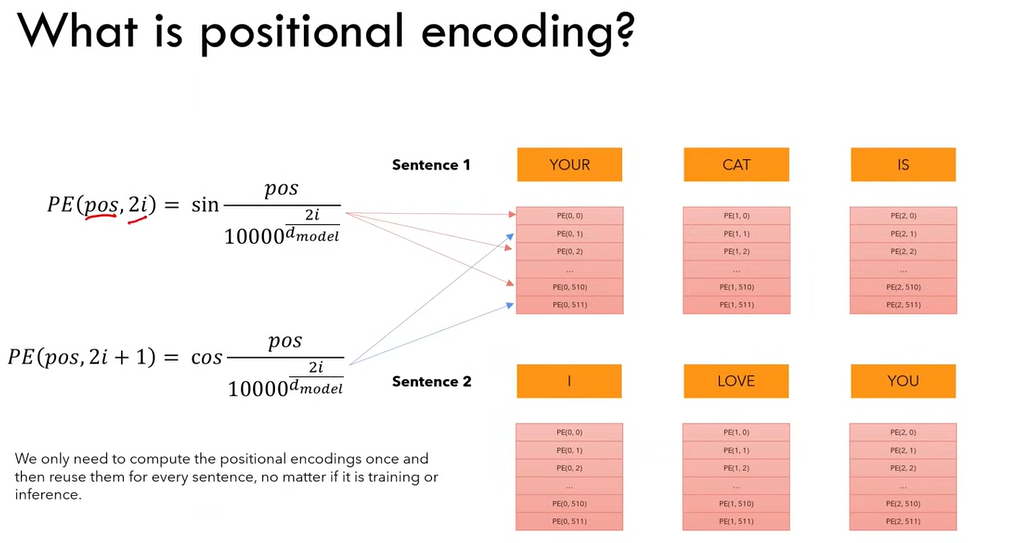

In [40]:
Image("Image/Positional_Encoding_minhhoa1.png")

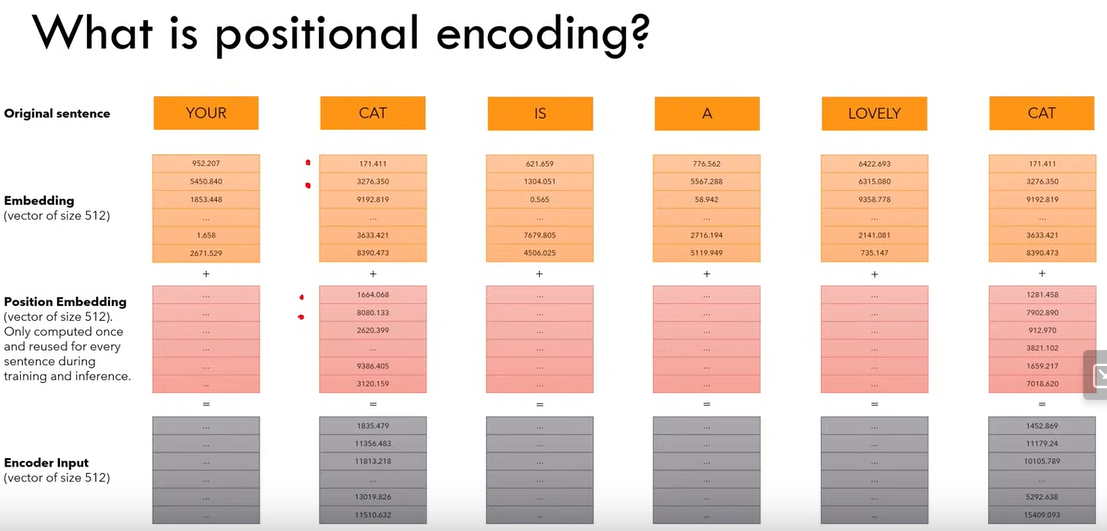

In [41]:
Image("Image/Positional_Encoding_minhhoa2.png")

In [47]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

**Example:**

In [42]:
# Example to test the PositionalEncoding class
d_model = 512  # Dimension of the embeddings
seq_len = 10   # Length of the sequence
dropout = 0.1  # Dropout rate
batch_size = 2 # Number of samples in the batch

# Create a dummy input tensor of shape (batch_size, seq_len, d_model)
# For this example, we'll simulate the embeddings, say we have some random values
input_embedding = torch.randn(batch_size, seq_len, d_model)

# Initialize the PositionalEncoding layer
pos_encoding = PositionalEncoding(d_model=d_model, seq_len=seq_len, dropout=dropout)

# Add positional encoding to the input
output = pos_encoding(input_embedding)

# Print input and output shapes
print("Input shape:", input_embedding.shape)  # Expected: (2, 10, 512)
print("Output shape:", output.shape)          # Expected: (2, 10, 512)

# Optionally, print a slice of the output to inspect the positional encoding added
print("Output sample (first example, first few positions):")
print(output[:, :5, :5])  # Print first 5 positions, first 5 dimensions for inspection

Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
Output sample (first example, first few positions):
tensor([[[-2.0707,  1.8200, -1.9033, -0.1020, -0.0410],
         [ 0.9419,  0.1356,  0.4992,  0.3003,  0.9110],
         [ 0.0947,  0.9336,  0.0000,  0.4005,  1.5668],
         [-1.9997, -1.7173,  1.0316, -1.7099,  0.5944],
         [-0.4115, -0.8446, -0.5339,  0.0244, -0.2515]],

        [[ 0.3238, -0.0000, -1.0247,  0.5214, -0.9524],
         [-0.3930,  0.0000,  1.8199,  1.0908,  3.3184],
         [ 2.3978, -0.5309,  0.9434,  0.1440,  1.0015],
         [-2.0769, -1.2538,  0.3641, -0.1486,  1.3844],
         [-0.9317, -0.0000, -0.0000,  0.4846, -2.5837]]])


- We got 2 different tensors here because we added input embeeding and positional embedding.

# 4. Layer Normalization

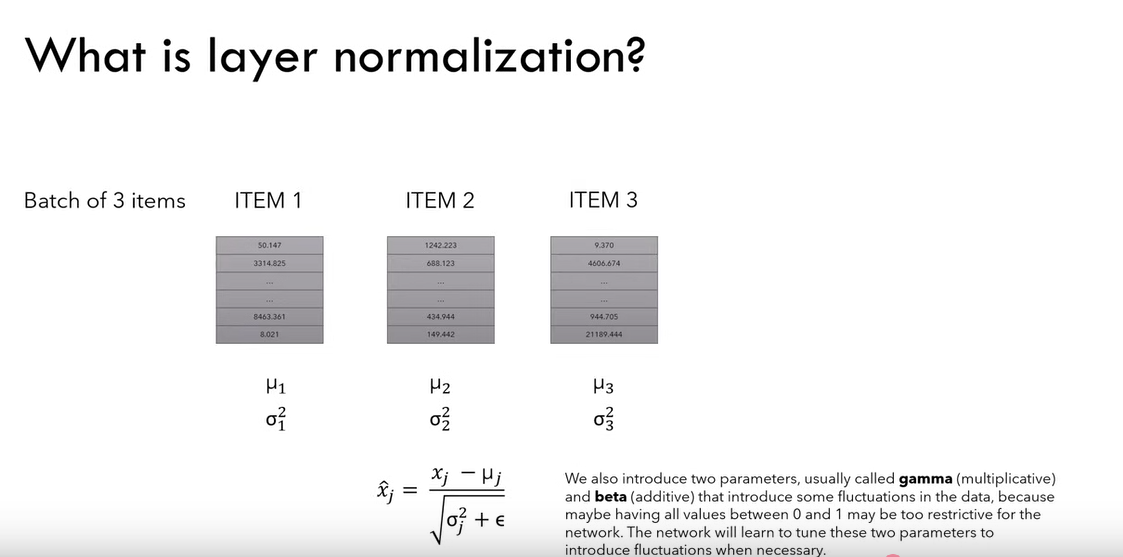

In [48]:
Image("Image/layer_normalization_minhhoa1.png")

- In above example, we have a batch of 3 items (like, 3 words), with different encoding, so we want to normalize to range (0,1).
- The paper show above formula, $\epsilon$ is small number you define, then have result R.
- We will learn 2 parameters, gamma and beta ($gamma$ R + $\beta$).

In [50]:
class LayerNormalization(nn.Module):
    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

**Difference between Batch normalization and Layer normalization**:
- Batch Normalization is applied across the batch dimension.
- Layer Normalization normalizes the activations across the features within each sample (instead of across the batch).

**For example**:
Sentence 1: [0.2, 0.3, 0.4]
Sentence 2: [0.1, 0.2, 0.3]
Sentence 3: [0.4, 0.5, 0.6]
Sentence 4: [0.3, 0.4, 0.5]

**Batch Normalization** computes the mean and variance of each feature across all sentences in the batch:
- For feature 1: mean = (0.2 + 0.1 + 0.4 + 0.3) / 4 = 0.25
- For feature 2: mean = (0.3 + 0.2 + 0.5 + 0.4) / 4 = 0.35
- For feature 3: mean = (0.4 + 0.3 + 0.6 + 0.5) / 4 = 0.45

**Layer Normalization** computes the mean and variance for each sentence independently:
- For Sentence 1: mean = (0.2 + 0.3 + 0.4) / 3 = 0.3
- For Sentence 2: mean = (0.1 + 0.2 + 0.3) / 3 = 0.2
- For Sentence 3: mean = (0.4 + 0.5 + 0.6) / 3 = 0.5
- For Sentence 4: mean = (0.3 + 0.4 + 0.5) / 3 = 0.4

**When to Use Each:**
- Batch Normalization is more suitable for **image** data or **fully connected networks** where the batch size is large and consistent. It requires a stable batch size because its normalization depends on batch statistics, which can vary with small batch sizes.
- Layer Normalization is more suitable for **sequential data** (e.g., text, time series) where the length of the sequence may vary, and the batch size could be small. This is why Transformers and RNNs prefer Layer Normalization, as each sequence is treated independently.

# 5. FeedForward
**In paper we see use max(0,...), but in code we use nn.Linear()...?**

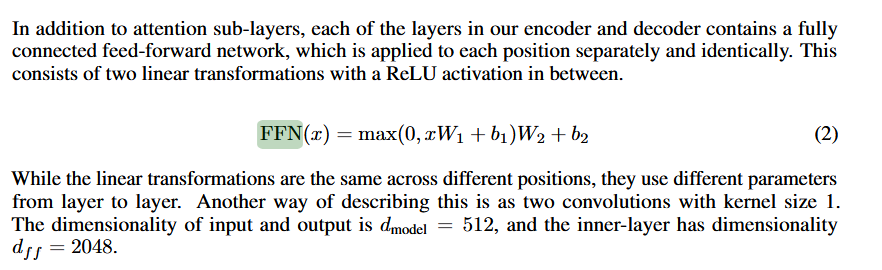

In [52]:
Image("Image/feedforward_formular.png")

In [51]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

# 6. Multi-head Attention
- Explain in explain.doc.
- Have 1 staticmethod attention here because it belong to a Class instead of an instance. This don't have any parameter.

In [53]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o(x)

# 7. Residual Connection
- We see in Transformer Architecture, like in input, 3 Q,K,V also contain 1 add directly into Layer Normalization, and also via FeedForWard, also one directly into Layer Normalization.

In [54]:
class ResidualConnection(nn.Module):
    
        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)
    
        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

# 8. Encoder
**Chỗ này cần giải thích ra vì sao có hai cái EncoderBlock, và Encoder** --> **Cần chạy thử nghiệm thì mới biết được.**
- Move to important part: Encoder, combine above Classes.

In [55]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [56]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# abc